In [74]:
#Data from https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
#Data size is relatively small
#Train with more data for better results.
#Might contain bugs that need to be reviewed.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip install rdkit

In [76]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [77]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [78]:
df = pd.read_parquet("de_train.parquet")

In [79]:
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [80]:
smiles=df['SMILES']

In [81]:
df = df.drop(['sm_name', 'sm_lincs_id','control', 'SMILES'], axis=1)

In [82]:
df.head()

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [143]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        self.categorical_column = 'cell_type'
        self.one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Separate columns
        self.numerical_columns = [col for col in X.columns if col != self.categorical_column]

        # Fit numerical imputer and scaler
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        self.scaler.fit(X_num_imputed)

        # Fit categorical imputer and one-hot encoder
        self.cat_imputer.fit(X[[self.categorical_column]])
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]])
        self.one_hot_encoder.fit(cell_type_imputed)

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Process numerical columns
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Process categorical column
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]])
        cell_type_encoded = self.one_hot_encoder.transform(cell_type_imputed)

        # Combine and return
        X_processed = np.hstack([cell_type_encoded, X_num_scaled])
        return X_processed

In [144]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [145]:
print(X_transformed.shape)

(614, 18217)


In [146]:
#Numerical features
num_num = len(preprocessor.numerical_columns)

In [150]:
cat_dim = preprocessor.one_hot_encoder.transform(
    preprocessor.cat_imputer.transform([['dummy']])
).shape[1]

print("Categorical feature and one-hot encoded column count:")
print(f"  cell_type: {cat_dim} one-hot columns")

print("Total features after transform:", cat_dim + len(preprocessor.numerical_columns))

Categorical feature and one-hot encoded column count:
  cell_type: 6 one-hot columns
Total features after transform: 18217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [152]:
# Number of one-hot encoded columns for 'cell_type'
cat_dims = [len(preprocessor.one_hot_encoder.categories_[0])]  # one-hot columns for 'cell_type'
num_num = len(preprocessor.numerical_columns)                  # numerical gene expression columns

print("Categorical feature and one-hot encoded column count:")
print(f"  cell_type: {cat_dims[0]} one-hot columns")

print("Total numerical features:", num_num)
print("Total features after transform:", cat_dims[0] + num_num)

Categorical feature and one-hot encoded column count:
  cell_type: 6 one-hot columns
Total numerical features: 18211
Total features after transform: 18217


In [153]:
smiles=np.array(smiles)

In [154]:
print(smiles.shape)

(614,)


In [155]:
print(X_transformed.shape)

(614, 18217)


In [156]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_smiles(smiles_list):
    # 1. Extract unique characters from SMILES strings
    charset = sorted(set("".join(smiles_list)))

    # 2. Create mapping from char → index (1-based indexing; 0 = padding)
    char_to_idx = {char: i + 1 for i, char in enumerate(charset)}
    idx_to_char = {i + 1: char for i, char in enumerate(charset)}

    # 3. Tokenize each SMILES into a list of indices
    encoded = [[char_to_idx[char] for char in smile] for smile in smiles_list]

    # 4. Pad sequences to the same length
    max_length = max(len(seq) for seq in encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=0)

    return np.array(padded), char_to_idx, idx_to_char, max_length

# === Tokenize your SMILES strings ===
smiles_encoded, char_to_idx, idx_to_char, max_smiles_length = tokenize_smiles(smiles)

In [157]:
#Generative MMD Autoencoder

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input

# === Encoder ===
def build_encoder(input_dim, latent_dim, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.GaussianNoise(noise_stddev)(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inputs, z, name="encoder")

# === Decoder ===
def build_decoder(latent_dim, vocab_size, max_length, embed_dim=64, l2_reg=1e-4):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = layers.Dense(max_length * embed_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(latent_inputs)
    x = layers.Reshape((max_length, embed_dim))(x)
    x = layers.Masking(mask_value=0.0)(x)  # <<< Add masking here to ignore padded timesteps
    x = layers.GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.TimeDistributed(layers.Dense(vocab_size + 1, activation='softmax'))(x)
    return Model(latent_inputs, outputs, name="decoder")

# === MMD Loss ===
def mmd_loss(z, prior_z, sigma=1.0):
    def gaussian_kernel(x, y, sigma):
        x_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
        y_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
        dist = x_norm - 2 * tf.matmul(x, tf.transpose(y)) + tf.transpose(y_norm)
        return tf.exp(-dist / (2.0 * sigma ** 2))

    k_xx = gaussian_kernel(z, z, sigma)
    k_yy = gaussian_kernel(prior_z, prior_z, sigma)
    k_xy = gaussian_kernel(z, prior_z, sigma)

    return tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)

In [158]:
#Optionally add gradient-clipping
@tf.function
def train_step(batch_x, batch_smiles, lambda_mmd=10.0):
    with tf.GradientTape() as tape:
        z = encoder(batch_x, training=True)
        prior_z = tf.random.normal(shape=tf.shape(z))
        decoded = decoder(z, training=True)
        recon_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(batch_smiles, decoded, from_logits=False))
        mmd = mmd_loss(z, prior_z)
        total_loss = recon_loss + lambda_mmd * mmd

    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return recon_loss, mmd, total_loss

# Set params
latent_dim = 32
batch_size = 64
epochs = 700
lambda_mmd = 1.0
input_dim = X_transformed.shape[1]
vocab_size = len(char_to_idx)
max_length = smiles_encoded.shape[1]

# Build models
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, vocab_size, max_length)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_transformed.astype(np.float32), smiles_encoded.astype(np.int32)))
dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Training loop
for epoch in range(epochs):
    recon_losses, mmd_losses, total_losses = [], [], []
    for batch_x, batch_smiles in dataset:
        recon, mmd, total = train_step(batch_x, batch_smiles, lambda_mmd)
        recon_losses.append(recon.numpy())
        mmd_losses.append(mmd.numpy())
        total_losses.append(total.numpy())
    print(f"Epoch {epoch+1}/{epochs} | Recon: {np.mean(recon_losses):.4f} | MMD: {np.mean(mmd_losses):.4f} | Total: {np.mean(total_losses):.4f}")

Epoch 1/700 | Recon: 3.4658 | MMD: 0.0379 | Total: 3.5037
Epoch 2/700 | Recon: 3.1836 | MMD: 0.0334 | Total: 3.2171
Epoch 3/700 | Recon: 2.5252 | MMD: 0.0334 | Total: 2.5585
Epoch 4/700 | Recon: 1.9335 | MMD: 0.0334 | Total: 1.9669
Epoch 5/700 | Recon: 1.7068 | MMD: 0.0334 | Total: 1.7402
Epoch 6/700 | Recon: 1.5974 | MMD: 0.0334 | Total: 1.6308
Epoch 7/700 | Recon: 1.5335 | MMD: 0.0334 | Total: 1.5669
Epoch 8/700 | Recon: 1.4907 | MMD: 0.0334 | Total: 1.5241
Epoch 9/700 | Recon: 1.4634 | MMD: 0.0334 | Total: 1.4968
Epoch 10/700 | Recon: 1.4382 | MMD: 0.0334 | Total: 1.4716
Epoch 11/700 | Recon: 1.4309 | MMD: 0.0334 | Total: 1.4643
Epoch 12/700 | Recon: 1.4225 | MMD: 0.0334 | Total: 1.4560
Epoch 13/700 | Recon: 1.4177 | MMD: 0.0334 | Total: 1.4511
Epoch 14/700 | Recon: 1.4050 | MMD: 0.0334 | Total: 1.4384
Epoch 15/700 | Recon: 1.4005 | MMD: 0.0334 | Total: 1.4339
Epoch 16/700 | Recon: 1.3918 | MMD: 0.0334 | Total: 1.4252
Epoch 17/700 | Recon: 1.3921 | MMD: 0.0334 | Total: 1.4255
Epoch 

In [159]:
import numpy as np
import pandas as pd

def generate_smiles(input_vector, encoder, decoder, idx_to_char, preprocessor=None,
                    num_samples=1, max_length=None, temperature=1.0):
    """
    Generate SMILES strings from a single input vector using a trained MMD autoencoder.

    Args:
        input_vector (np.ndarray or pd.Series or dict): Raw or preprocessed input.
        encoder (tf.keras.Model): Trained encoder model.
        decoder (tf.keras.Model): Trained decoder model.
        idx_to_char (dict): Mapping from token index to character.
        preprocessor (Transformer, optional): Fitted preprocessor for input transformation.
        num_samples (int): Number of SMILES strings to generate.
        max_length (int, optional): Maximum sequence length to generate.
        temperature (float): Sampling temperature. Higher = more random.

    Returns:
        str or list of str: Generated SMILES string(s).
    """
    # Convert input_vector to DataFrame if needed
    if preprocessor is not None:
        if isinstance(input_vector, dict):
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, pd.Series):
            input_vector = input_vector.to_frame().T
        elif isinstance(input_vector, np.ndarray):
            if input_vector.ndim == 1:
                input_vector = input_vector.reshape(1, -1)
            input_vector = pd.DataFrame(input_vector, columns=preprocessor.numerical_columns +
                                        list(preprocessor.one_hot_encoder.get_feature_names_out([preprocessor.categorical_column])))
        # Apply preprocessing
        input_vector = preprocessor.transform(input_vector)

    # Ensure input shape is 2D
    input_vector = np.array(input_vector, dtype=np.float32)
    if input_vector.ndim == 1:
        input_vector = np.expand_dims(input_vector, axis=0)

    # Encode input into latent space
    z = encoder.predict(input_vector, verbose=0)

    # Decode latent vector into sequence logits
    decoded_seq = decoder.predict(z, verbose=0)  # shape: (1, max_length, vocab_size+1)
    if max_length is None:
        max_length = decoded_seq.shape[1]

    vocab_size_plus = decoded_seq.shape[2]

    # Generate SMILES strings with temperature sampling
    samples = []
    for _ in range(num_samples):
        smiles_chars = []
        for t in range(max_length):
            logits = decoded_seq[0, t]  # shape: (vocab_size+1,)
            logits = np.log(logits + 1e-9) / temperature  # apply temperature
            probs = np.exp(logits) / np.sum(np.exp(logits))

            token_idx = np.random.choice(vocab_size_plus, p=probs)
            if token_idx == 0:  # padding or end-of-sequence token
                break
            smiles_chars.append(idx_to_char.get(token_idx, ''))  # fallback to '' if token not in dict
        samples.append(''.join(smiles_chars))

    return samples if num_samples > 1 else samples[0]

In [160]:
# Choose a temperature (e.g., 0.7 for conservative, 1.0 for standard, 1.5+ for diverse)
temperature = 1.5

# Set number of samples
num_samples = 120000

# Optionally add preprocessor if you're using raw input (like a dict or DataFrame row)
# Example with preprocessor:
# input_data = your_raw_input_dict_or_dataframe_row
# generated_smiles_list = generate_smiles(input_data, encoder, decoder, idx_to_char,
#                                         preprocessor=preprocessor,
#                                         num_samples=num_samples,
#                                         max_length=max_smiles_length,
#                                         temperature=temperature)

# If using already preprocessed input:
generated_smiles_list = generate_smiles(
    input_vector=X_transformed[0],
    encoder=encoder,
    decoder=decoder,
    idx_to_char=idx_to_char,
    num_samples=num_samples,
    max_length=max_smiles_length,
    temperature=temperature
)

In [161]:
from rdkit import Chem
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None and len(smi) >= 5:
            valid_smiles.append(smi)
    return valid_smiles

In [162]:
valid_smiles = filter_valid_smiles(set(generated_smiles_list))

In [163]:
print(len(valid_smiles))

440



**Molecule 1:** `Clc1ccCc/1C(c1ccccc1)(c1ccccc1)n1ccnc1`  
- **logP:** 5.13  
- **MolWt:** 332.83  
- **TPSA:** 17.82  
- **QED:** 0.647  
- **SA Score:** 2.84  
- **SASA:** 382.66  


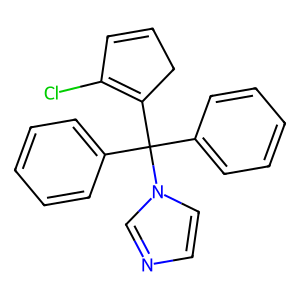


**Molecule 2:** `NOc1ccccc1C(c1ccccc1)(c1ccccc1)n1ncnc1`  
- **logP:** 3.37  
- **MolWt:** 342.40  
- **TPSA:** 65.96  
- **QED:** 0.446  
- **SA Score:** 2.53  
- **SASA:** 409.30  


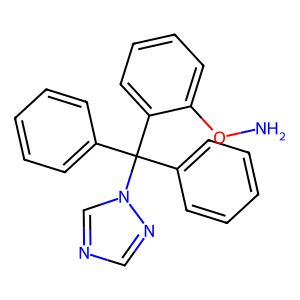


**Molecule 3:** `Clc1ccccc1C(c1cnccc1)`  
- **logP:** 3.33  
- **MolWt:** 203.67  
- **TPSA:** 12.89  
- **QED:** 0.730  
- **SA Score:** 1.62  
- **SASA:** 243.69  


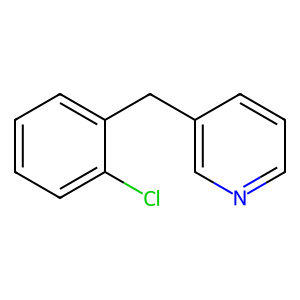


**Molecule 4:** `CCc1ccccccC(c1ccccc1)(ccccccc1)n1ccnc1`  
- **logP:** 6.32  
- **MolWt:** 366.51  
- **TPSA:** 17.82  
- **QED:** 0.599  
- **SA Score:** 4.82  
- **SASA:** 514.13  


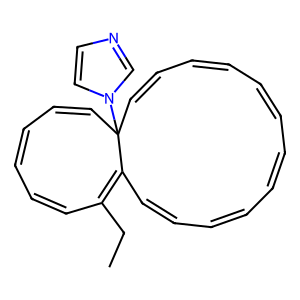


**Molecule 5:** `CCc1ccccc1C(c1cc1cc1)(ccccccc1)n1ccnc1`  
- **logP:** 5.29  
- **MolWt:** 338.45  
- **TPSA:** 17.82  
- **QED:** 0.743  
- **SA Score:** 4.37  
- **SASA:** 461.50  


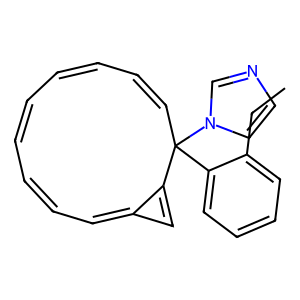


**Molecule 6:** `COc1ccccc1C(c1ccccc1)(c1ccccc1)C1ccnc1`  
- **logP:** 5.24  
- **MolWt:** 339.44  
- **TPSA:** 21.59  
- **QED:** 0.582  
- **SA Score:** 3.11  
- **SASA:** 426.01  


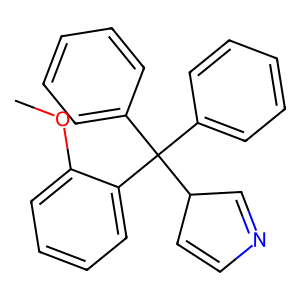


**Molecule 7:** `Clc1ccccccC(ccccccc1)(c1ccccc1)n1ccnc1`  
- **logP:** 6.10  
- **MolWt:** 372.90  
- **TPSA:** 17.82  
- **QED:** 0.622  
- **SA Score:** 4.36  
- **SASA:** 476.82  


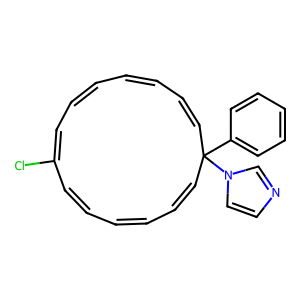


**Molecule 8:** `Clc1ccccc1C(c1ccccc1)(c1ccncc1)n1cnnc1`  
- **logP:** 4.17  
- **MolWt:** 346.82  
- **TPSA:** 43.60  
- **QED:** 0.557  
- **SA Score:** 2.99  
- **SASA:** 378.43  


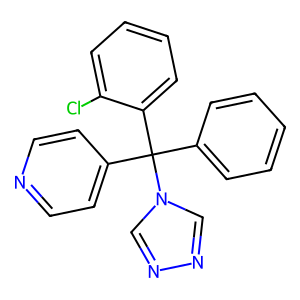


**Molecule 9:** `Clc1ccccccCCc1`  
- **logP:** 3.57  
- **MolWt:** 166.65  
- **TPSA:** 0.00  
- **QED:** 0.516  
- **SA Score:** 3.64  
- **SASA:** 230.26  


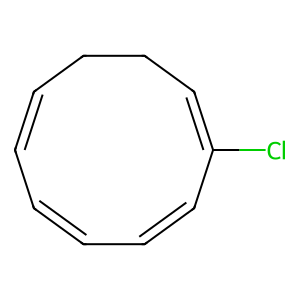


**Molecule 10:** `Clc1ccccccC(c1ccccc1)(ccccccc1)n1ccnc1`  
- **logP:** 6.10  
- **MolWt:** 372.90  
- **TPSA:** 17.82  
- **QED:** 0.582  
- **SA Score:** 4.81  
- **SASA:** 475.38  


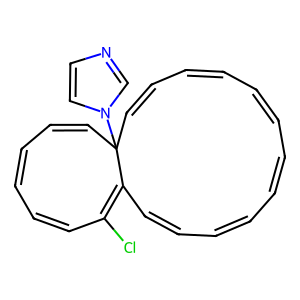

In [164]:
#Implement Lipinski-Rule of Five and show top-k molecules that pass filter along with properties.
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, QED, AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdFreeSASA import CalcSASA, classifyAtoms, SASAOpts
from rdkit.Chem import RDConfig
from IPython.display import display, Markdown

# Load sascorer from RDKit contrib
sascorer_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
if sascorer_path not in sys.path:
    sys.path.append(sascorer_path)

import sascorer

# Show top valid molecules with properties
top_k = 10
subset = valid_smiles[:top_k]

for i, smi in enumerate(subset):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Invalid SMILES: {smi}")
        continue

    # Compute descriptors
    logp    = Crippen.MolLogP(mol)
    molwt   = Descriptors.MolWt(mol)
    qed     = QED.qed(mol)
    sa_score = sascorer.calculateScore(mol)
    tpsa    = rdMolDescriptors.CalcTPSA(mol)

    # Try to compute SASA (requires 3D structure)
    try:
        mol3d = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        radii = classifyAtoms(mol3d, SASAOpts())
        sasa  = CalcSASA(mol3d, radii)
    except Exception as e:
        sasa = None

    # Format values safely
    props = f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** {sasa:.2f}
""" if sasa is not None else f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** N/A
"""

    display(Markdown(props))
    display(Draw.MolToImage(mol, size=(300, 300)))

In [166]:
len(valid_smiles)

440

In [167]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import numpy as np

def plot_smiles_clusters(smiles_list, max_clusters=10):
    # Convert SMILES to Morgan fingerprints
    fps = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            fps.append(fp)
            valid_smiles.append(smi)

    if not fps:
        print("No valid molecules found.")
        return

    # Convert fingerprints to numpy array
    arr = np.array([np.array(list(fp.ToBitString()), dtype=int) for fp in fps])

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate='auto')
    reduced = tsne.fit_transform(arr)

    # Find optimal number of clusters using GMM with BIC
    bic_scores = []
    models = []
    for n in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(reduced)
        bic = gmm.bic(reduced)
        bic_scores.append(bic)
        models.append(gmm)

    # Choose best model
    best_n = np.argmin(bic_scores) + 2  # +2 because range starts at 2
    best_gmm = models[best_n - 2]
    labels = best_gmm.predict(reduced)

    # Plot t-SNE with clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolors='k')
    plt.title(f'GMM Clustering of Molecules (Optimal Clusters: {best_n})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()

    # Optional: return clustering info
    #return {
     #   "reduced_coords": reduced,
      #  "labels": labels,
       # "bic_scores": bic_scores,
       # "optimal_n": best_n,
       # "valid_smiles": valid_smiles
   # }

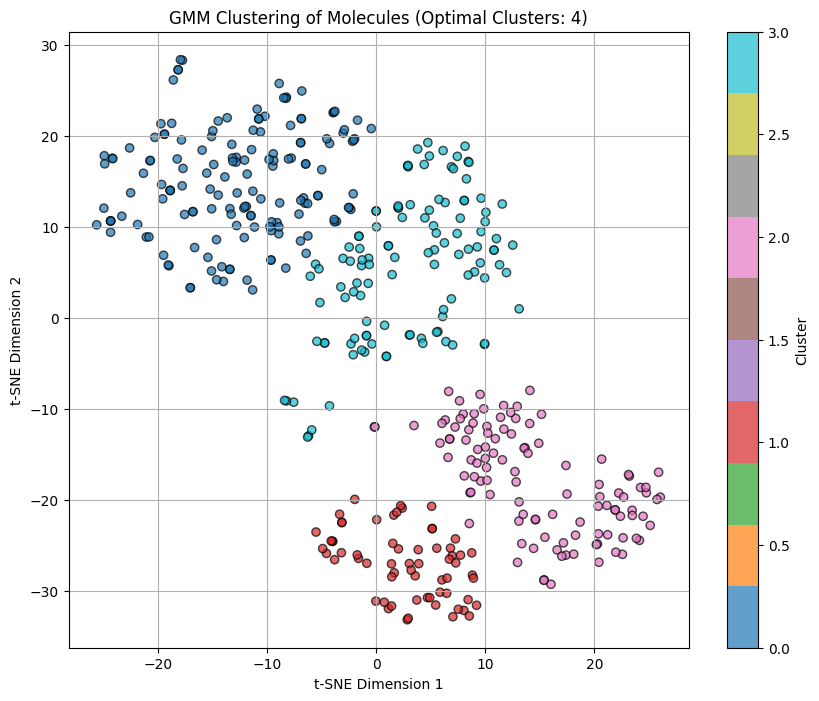

In [168]:
plot_smiles_clusters(valid_smiles, max_clusters=10)